In [1]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=61241333fd63395d1509037b8d3bf57f3a375659644d9af59c119e6c6f485b4b
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


In [2]:
!pip install jsonlines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from modulefinder import packagePathMap
from unittest import result
from click import pass_obj
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
import json
import jsonlines
import numpy as np
import math
import os
import argparse
import statistics
import codecs
import json
import csv
from transformers import DistilBertModel, DistilBertTokenizer
import torch

In [4]:
configuration = {
    'n_layers': 4,
    'dropout_prob': 0.2,
    'qa_droput': 0.2,
    'activation': 'relu'
}

In [5]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased', num_labels=2, dropout=configuration['dropout_prob'], n_layers=configuration['n_layers'], qa_dropout=configuration['qa_droput'], activation=configuration['activation'])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['distilbert.transformer.layer.5.attention.k_lin.weight', 'distilbert.transformer.layer.5.ffn.lin2.weight', 'distilbert.transformer.layer.5.attention.out_lin.bias', 'distilbert.transformer.layer.4.attention.out_lin.bias', 'vocab_projector.weight', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.4.attention.v_lin.weight', 'distilbert.transformer.layer.5.attention.v_lin.weight', 'distilbert.transformer.layer.4.ffn.lin2.weight', 'distilbert.transformer.layer.4.attention.q_lin.bias', 'vocab_transform.bias', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.5.attention.out_lin.weight', 'distilbert.transformer.layer.4.sa_layer_norm.bias', 'distilbert.transformer.layer.4.attention.k_lin.bias', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.4.attentio

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
def create_embeddings_distilbert(sentence):
  inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt", max_length=65536)
  return model(**inputs).last_hidden_state[:, 0, :]

In [8]:
class get_doc:
    def __init__(self, paper_id, metadata, title, abstract, pred_labels_truncated, pred_labels):
      self.paper_id = paper_id
      self.metadata = metadata
      self.title = title
      self.abstract = abstract
      self.pred_labels_truncated = pred_labels_truncated
      self.pred_labels = pred_labels

docs = {}

with jsonlines.open('/content/drive/MyDrive/data/abstracts-csfcube-preds.jsonl') as doc:
  for section in doc:
    docs[section['paper_id']] = get_doc(section['paper_id'], section['metadata'], section['title'], section['abstract'], section['pred_labels_truncated'], section['pred_labels'])
print(docs)

{'7632414': <__main__.get_doc object at 0x7fd6f109c2b0>, '143814895': <__main__.get_doc object at 0x7fd6f109c310>, '62097085': <__main__.get_doc object at 0x7fd6f107ff10>, '16421850': <__main__.get_doc object at 0x7fd6f107f310>, '6219199': <__main__.get_doc object at 0x7fd6f107f460>, '17900194': <__main__.get_doc object at 0x7fd6f107fdf0>, '5649696': <__main__.get_doc object at 0x7fd6f107f8e0>, '18051931': <__main__.get_doc object at 0x7fd6f107fe80>, '7395053': <__main__.get_doc object at 0x7fd6f107f1f0>, '101871': <__main__.get_doc object at 0x7fd6f107f610>, '2946395': <__main__.get_doc object at 0x7fd6f107fc10>, '1042076': <__main__.get_doc object at 0x7fd6f107fdc0>, '921607': <__main__.get_doc object at 0x7fd6f107f700>, '2282762': <__main__.get_doc object at 0x7fd6f107fd00>, '22350021': <__main__.get_doc object at 0x7fd6f107fa60>, '14492070': <__main__.get_doc object at 0x7fd6f107f760>, '63244878': <__main__.get_doc object at 0x7fd6f0a5c7c0>, '120362896': <__main__.get_doc object at

In [9]:
!mkdir /content/drive/MyDrive/Results/distil_bert_tuned

mkdir: cannot create directory ‘/content/drive/MyDrive/Results/distil_bert_tuned’: File exists


In [10]:
def get_data_by_facet(pid, facet):
  predLabels = {'background' : ['background_label', 'objective_label'], 'method' : ['method_label'], 'result' : ['result_label']}
  doc = docs[pid];
  temp = list()
  for pred_index in range(len(doc.pred_labels)):
    if doc.pred_labels[pred_index] in predLabels[facet]:
      temp.append(doc.abstract[pred_index])

  return temp

In [11]:
f = open('/content/drive/MyDrive/data/test-pid2anns-csfcube-background.json')
background_query = json.load(f)
background_query_ids = list(background_query.keys())
print(background_query_ids)

f = open('/content/drive/MyDrive/data/test-pid2anns-csfcube-method.json')
method_query = json.load(f)
method_query_ids = list(method_query.keys())
print(method_query_ids)

f = open('/content/drive/MyDrive/data/test-pid2anns-csfcube-result.json')
result_query = json.load(f)
result_query_ids = list(result_query.keys())
print(result_query_ids)

['10014168', '10695055', '5764728', '51977123', '929877', '3264891', '1936997', '11844559', '8781666', '1587', '189897839', '6173686', '7898033', '52194540', '1791179', '6431039']
['1198964', '11310392', '10010426', '53080736', '53082542', '1791179', '2468783', '80628431', '189897839', '52194540', '929877', '1936997', '102353905', '5052952', '13949438', '174799296', '5270848']
['1198964', '10052042', '11629674', '1587', '174799296', '1306065', '53080736', '2090262', '2865563', '11844559', '2468783', '5052952', '2360770', '3264891', '6431039', '80628431', '8781666']


In [ ]:
# for all
d = dict()
err_pids = list()
i = 0
cnt = 0;
init_cnt = 0;
for doc in docs:
  try:
      do = docs[doc].abstract
      if len(do) == 0:
          d[doc] = list()
          continue
      get_specter = create_embeddings_distilbert(" ".join(do)).detach().numpy().tolist()
      cnt += 1
      print(cnt)
      d[doc] = get_specter[0]
  except:
        err_pids.append(doc)
print(f'len(err_pids) = {len(err_pids)}')
print(err_pids)
with open('/content/drive/MyDrive/Results/distil_bert_tuned/all.json', 'w') as outfile:
    json.dump(d, outfile)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
d = json.load(open('/content/drive/MyDrive/Results/distil_bert_tuned/all.json'),
              parse_float=lambda x: round(float(x), 6))
with open('/content/drive/MyDrive/Results/distil_bert_tuned/all.json', 'w') as outfile:
    json.dump(d, outfile)

In [12]:
# specter queries
for i, ids in enumerate([background_query_ids, method_query_ids, result_query_ids]):
    d = dict()
    err_pids = list()
    s = ''
    if i == 0:
        s = 'background'
    elif i == 1:
        s = 'method'
    elif i == 2:
        s = 'result'
    for pid in ids:
        doc = get_data_by_facet(pid, s)
        if len(doc) == 0:
            d[pid] = list()
            continue
        specter_array = create_embeddings_distilbert(" ".join(doc)).detach().numpy().tolist()
        d[pid] = specter_array[0]
    print(f'len(err_pids), {s} = {len(err_pids)}')
    print(err_pids)
    with open(f'/content/drive/MyDrive/Results/distil_bert_tuned/{s}.json', 'w') as outfile:
        json.dump(d, outfile)
    d = json.load(open(f'/content/drive/MyDrive/Results/distil_bert_tuned/{s}.json'),
                parse_float=lambda x: round(float(x), 6))
    with open(f'/content/drive/MyDrive/Results/distil_bert_tuned/{s}.json', 'w') as outfile:
        json.dump(d, outfile)

Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.


len(err_pids), background = 0
[]


Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.


len(err_pids), method = 0
[]


Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.
Keyword arguments {'n_jobs': -1} not recognized.


len(err_pids), result = 0
[]


In [14]:
def create_embeddings_distilbert(sentence, tokenizer, model):
  inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt", max_length=65536)
  return model(**inputs).last_hidden_state[:, 0, :]

def train(layer):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased', num_labels=2, n_layers=layer)

    # query tokenizers
    for i, ids in enumerate([background_query_ids, method_query_ids, result_query_ids]):
        d = dict()
        err_pids = list()
        s = ''
        if i == 0:
            s = 'background'
        elif i == 1:
            s = 'method'
        elif i == 2:
            s = 'result'
        for pid in ids:
            doc = get_data_by_facet(pid, s)
            if len(doc) == 0:
                d[pid] = list()
                continue
            specter_array = create_embeddings_distilbert(" ".join(doc), tokenizer, model).detach().numpy().tolist()
            d[pid] = specter_array[0]
        print(f'len(err_pids), {s} = {len(err_pids)}')
        print(err_pids)
        with open(f'/content/drive/MyDrive/Results/distil_bert_tuned/{s}.json', 'w') as outfile:
            json.dump(d, outfile)
        d = json.load(open(f'/content/drive/MyDrive/Results/distil_bert_tuned/{s}.json'),
                    parse_float=lambda x: round(float(x), 6))
        with open(f'/content/drive/MyDrive/Results/distil_bert_tuned/{s}.json', 'w') as outfile:
            json.dump(d, outfile)

    # document tokenizers
    d = dict()
    err_pids = list()
    i = 0
    cnt = 0;
    init_cnt = 0;
    for doc in docs:
      try:
          do = docs[doc].abstract
          if len(do) == 0:
              d[doc] = list()
              continue
          get_specter = create_embeddings_distilbert(" ".join(do), tokenizer, model).detach().numpy().tolist()
          cnt += 1
          print(cnt)
          d[doc] = get_specter[0]
      except:
            err_pids.append(doc)
    print(f'len(err_pids) = {len(err_pids)}')
    print(err_pids)
    with open('/content/drive/MyDrive/Results/distil_bert_tuned/all.json', 'w') as outfile:
        json.dump(d, outfile)
    d = json.load(open('/content/drive/MyDrive/Results/distil_bert_tuned/all.json'),
              parse_float=lambda x: round(float(x), 6))
    with open('/content/drive/MyDrive/Results/distil_bert_tuned/all.json', 'w') as outfile:
        json.dump(d, outfile)

## GETTING RESULTS

In [15]:
def cosine_similarity(doc1, doc2):
  a = np.asarray(doc1)
  b = np.asarray(doc2)
  cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

  return cos_sim

In [16]:
def r_precision(r):
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def recall_at_k(ranked_rel, atk, max_total_relevant):
    # print(ranked_rel)
    total_relevant = sum(ranked_rel)
    # total_relevant = min(max_total_relevant, len(ranked_rel))
    total_relevant = min(max_total_relevant, total_relevant)
    relatk = sum(ranked_rel[:atk])
    # print(relatk, total_relevant)
    if total_relevant > 0:
        recall_atk = float(relatk)/total_relevant
    else:
        recall_atk = 0.0
    return recall_atk

In [17]:
facet2folds = {
    "background": {"fold1_dev": ["3264891_background", "1936997_background", "11844559_background",
                                 "52194540_background", "1791179_background", "6431039_background",
                                 "6173686_background", "7898033_background"],
                   "fold2_dev": ["5764728_background", "10014168_background", "10695055_background",
                                 "929877_background", "1587_background", "51977123_background",
                                 "8781666_background", "189897839_background"],
                   "fold1_test": ["5764728_background", "10014168_background", "10695055_background",
                                  "929877_background", "1587_background", "51977123_background",
                                  "8781666_background", "189897839_background"],
                   "fold2_test": ["3264891_background", "1936997_background", "11844559_background",
                                  "52194540_background", "1791179_background", "6431039_background",
                                  "6173686_background", "7898033_background"]},
    "method": {"fold1_dev": ["189897839_method", "1791179_method", "11310392_method", "2468783_method",
                             "13949438_method", "5270848_method", "52194540_method", "929877_method"],
               "fold2_dev": ["5052952_method", "10010426_method", "102353905_method", "174799296_method",
                             "1198964_method", "53080736_method", "1936997_method", "80628431_method",
                             "53082542_method"],
               "fold1_test": ["5052952_method", "10010426_method", "102353905_method", "174799296_method",
                              "1198964_method", "53080736_method", "1936997_method", "80628431_method",
                              "53082542_method"],
               "fold2_test": ["189897839_method", "1791179_method", "11310392_method", "2468783_method",
                              "13949438_method", "5270848_method", "52194540_method", "929877_method"]},
    "result": {"fold1_dev": ["2090262_result", "174799296_result", "11844559_result", "2468783_result",
                             "1306065_result", "5052952_result", "3264891_result", "8781666_result"],
               "fold2_dev": ["2865563_result", "10052042_result", "11629674_result", "1587_result",
                             "1198964_result", "53080736_result", "2360770_result", "80628431_result",
                             "6431039_result"],
               "fold1_test": ["2865563_result", "10052042_result", "11629674_result", "1587_result",
                              "1198964_result", "53080736_result", "2360770_result", "80628431_result",
                              "6431039_result"],
               "fold2_test": ["2090262_result", "174799296_result", "11844559_result", "2468783_result",
                              "1306065_result", "5052952_result", "3264891_result", "8781666_result"]},
    "all": {"fold1_dev": ["3264891_background", "1936997_background", "11844559_background",
                          "52194540_background", "1791179_background", "6431039_background",
                          "6173686_background", "7898033_background", "189897839_method",
                          "1791179_method", "11310392_method", "2468783_method", "13949438_method",
                          "5270848_method", "52194540_method", "929877_method", "2090262_result",
                          "174799296_result", "11844559_result", "2468783_result", "1306065_result",
                          "5052952_result", "3264891_result", "8781666_result"],
            "fold2_dev": ["5764728_background", "10014168_background", "10695055_background",
                          "929877_background", "1587_background", "51977123_background",
                          "8781666_background", "189897839_background", "5052952_method", "10010426_method",
                          "102353905_method", "174799296_method", "1198964_method", "53080736_method",
                          "1936997_method", "80628431_method", "53082542_method", "2865563_result",
                          "10052042_result", "11629674_result", "1587_result", "1198964_result",
                          "53080736_result", "2360770_result", "80628431_result", "6431039_result"],
            "fold1_test": ["5764728_background", "10014168_background", "10695055_background",
                           "929877_background", "1587_background", "51977123_background", "8781666_background",
                           "189897839_background", "5052952_method", "10010426_method", "102353905_method",
                           "174799296_method", "1198964_method", "53080736_method", "1936997_method",
                           "80628431_method", "53082542_method", "2865563_result", "10052042_result",
                           "11629674_result", "1587_result", "1198964_result", "53080736_result",
                           "2360770_result", "80628431_result", "6431039_result"],
            "fold2_test": ["3264891_background", "1936997_background", "11844559_background",
                           "52194540_background", "1791179_background", "6431039_background",
                           "6173686_background", "7898033_background", "189897839_method", "1791179_method",
                           "11310392_method", "2468783_method", "13949438_method", "5270848_method",
                           "52194540_method", "929877_method", "2090262_result", "174799296_result",
                           "11844559_result", "2468783_result", "1306065_result", "5052952_result",
                           "3264891_result", "8781666_result"]
            }
}

In [18]:
def read_facet_specific_relevances(data_path, run_path, dataset, facet, method_name):
    """
    Read the gold data and the model rankings and the relevances for the
    model.
    :param data_path: string; directory with gold citations for test pids and rankings
        from baseline methods in subdirectories.
    :param run_path: string; directory with ranked candidates for baselines a subdir of
        data_path else is a model run.
    :param method_name: string; method with which ranks were created.
    :param dataset: string; eval dataset.
    :param facet: string; facet for eval.
    :return: qpid2rankedcand_relevances: dict('qpid_facet': [relevances]);
        candidate gold relevances for the candidates in order ranked by the
        model.
    """
    gold_fname = os.path.join(data_path, 'test-pid2anns-{:s}-{:s}.json'.format(dataset, facet))
    ranked_fname = os.path.join(run_path, method_name, 'test-pid2pool-{:s}-{:s}-{:s}-ranked.json'.
                                format(dataset, method_name, facet))
    # Load gold test data (citations).
    with codecs.open(gold_fname, 'r', 'utf-8') as fp:
        pid2pool_source = json.load(fp)
        num_query = len(pid2pool_source)
        print('Gold query pids: {:d}'.format(num_query))
        pid2rels_gold = {}
        for qpid, pool_rel in pid2pool_source.items():
            pool = pool_rel['cands']
            cands_rels = pool_rel['relevance_adju']
            pid2rels_gold['{:s}_{:s}'.format(qpid, facet)] = dict([(pid, rel) for pid, rel in zip(pool, cands_rels)])
    # Load ranked predictions on test data with methods.
    with codecs.open(ranked_fname, 'r', 'utf-8') as fp:
        pid2ranks = json.load(fp)
        print('Valid ranked query pids: {:d}'.format(len(pid2ranks)))
        qpid2rankedcand_relevances = {}
        for qpid, citranks in pid2ranks.items():
            candpids = [pid_score[0] for pid_score in citranks]
            cand_relevances = [pid2rels_gold['{:s}_{:s}'.format(qpid, facet)][pid] for pid in candpids]
            qpid2rankedcand_relevances['{:s}_{:s}'.format(qpid, facet)] = cand_relevances
    return qpid2rankedcand_relevances


def read_all_facet_relevances(data_path, run_path, dataset, method_name, facets):
    """
    Read the gold data and the model rankings and the relevances for the
    model.
    :param data_path: string; directory with gold citations for test pids and rankings
        from baseline methods in subdirectories.
    :param run_path: string; directory with ranked candidates for baselines a subdir of
        data_path else is a model run.
    :param method_name: string; method with which ranks were created.
    :param dataset: string; eval dataset.
    :param facets: list(string); what facets to read/what counts as "all".
    :return: qpid2rankedcand_relevances: dict('qpid_facet': [relevances]);
        candidate gold relevances for the candidates in order ranked by the
        model.
    """
    qpid2rankedcand_relevances = {}
    for facet in facets:
        print('Reading facet: {:s}'.format(facet))
        gold_fname = os.path.join(data_path, 'test-pid2anns-{:s}-{:s}.json'.format(dataset, facet))
        ranked_fname = os.path.join(run_path, method_name, 'test-pid2pool-{:s}-{:s}-{:s}-ranked.json'.
                                    format(dataset, method_name, facet))
        # Load gold test data (citations).
        with codecs.open(gold_fname, 'r', 'utf-8') as fp:
            pid2pool_source = json.load(fp)
            num_query = len(pid2pool_source)
            print('Gold query pids: {:d}'.format(num_query))
            pid2rels_gold = {}
            for qpid, pool_rel in pid2pool_source.items():
                pool = pool_rel['cands']
                cands_rels = pool_rel['relevance_adju']
                pid2rels_gold['{:s}_{:s}'.format(qpid, facet)] = \
                    dict([(pid, rel) for pid, rel in zip(pool, cands_rels)])
        # Load ranked predictions on test data with methods.
        with codecs.open(ranked_fname, 'r', 'utf-8') as fp:
            pid2ranks = json.load(fp)
            print('Valid ranked query pids: {:d}'.format(len(pid2ranks)))
            for qpid, citranks in pid2ranks.items():
                candpids = [pid_score[0] for pid_score in citranks]
                cand_relevances = [pid2rels_gold['{:s}_{:s}'.format(qpid, facet)][pid] for pid in candpids]
                qpid2rankedcand_relevances['{:s}_{:s}'.format(qpid, facet)] = cand_relevances
    print('Total queries: {:d}'.format(len(qpid2rankedcand_relevances)))
    return qpid2rankedcand_relevances

In [19]:
def compute_metrics(ranked_judgements, pr_atk, threshold_grade):
    """
    Given the ranked judgements compute the metrics for a query.
    :param ranked_judgements: list(int); graded or binary relevances in rank order.
    :param pr_atk: int; the @K value to use for computing precision and recall.
    :param threshold_grade: int; Assuming 0-3 graded relevances, threshold at some point
        and convert graded to binary relevance.
    :return:
    """
    graded_judgements = ranked_judgements
    ranked_judgements = [1 if rel >= threshold_grade else 0 for rel in graded_judgements]
    # Use the full set of candidate not the pr_atk.
    ndcg = ndcg_at_k(graded_judgements, len(ranked_judgements))
    ndcg_pr = ndcg_at_k(graded_judgements, int(0.20*len(ranked_judgements)))
    ndcg_20 = ndcg_at_k(graded_judgements, 20)
    max_total_relevant = sum(ranked_judgements)
    recall = recall_at_k(ranked_rel=ranked_judgements,
                         atk=pr_atk, max_total_relevant=max_total_relevant)
    precision = precision_at_k(r=ranked_judgements, k=pr_atk)
    precision_r = r_precision(r=ranked_judgements)
    av_precision = average_precision(r=ranked_judgements)
    metrics = {
        'recall': float(recall),
        'precision': float(precision),
        'r_precision': float(precision_r),
        'av_precision': float(av_precision),
        'ndcg': ndcg,
        'ndcg@20': ndcg_20,
        'ndcg%20': ndcg_pr
    }
    return metrics

In [20]:
def aggregate_metrics_crossval(query_metrics, split_str, facet_str):
    """
    Given metrics over individual queries aggregate over different
    queries.
    :param query_metrics: dict(query_id: metrics_dict from compute_metrics)
    :param split_str: string; {dev, test}
    :param facet_str: string; {background, method, result}
    :return:
    """
    aggmetrics = {
        'precision': [],
        'recall': [],
        'r_precision': [],
        'mean_av_precision': [],
        'ndcg': [],
        'ndcg@20': [],
        'ndcg%20': []
    }
    # For dev only use a part of the fold - using both makes it identical to test.
    if split_str == 'dev':
        folds = ['fold1_{:s}'.format(split_str)]
    elif split_str == 'test':
        folds = ['fold1_{:s}'.format(split_str), 'fold2_{:s}'.format(split_str)]
    for fold_str in folds:
        fold_pids = facet2folds[facet_str][fold_str]
        precision, recall, f1, av_precision, mrr, ndcg, r_precision = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        ndcg_20, ndcg_pr = 0.0, 0.0
        for query_id in fold_pids:
            # Aggregate across paper types in the fold.
            metrics = query_metrics[query_id]
            # Aggregate across all papers in the fold
            precision += metrics['precision']
            recall += metrics['recall']
            av_precision += metrics['av_precision']
            r_precision += metrics['r_precision']
            ndcg += metrics['ndcg']
            ndcg_20 += metrics['ndcg@20']
            ndcg_pr += metrics['ndcg%20']
        # Average all folds
        num_queries = len(fold_pids)
        precision, recall, f1 = precision/num_queries, recall/num_queries, f1/num_queries
        av_precision = av_precision/num_queries
        mrr, ndcg, r_precision = mrr/num_queries, ndcg/num_queries, r_precision/num_queries
        ndcg_20, ndcg_pr = ndcg_20/num_queries, ndcg_pr/num_queries
        # Save the averaged metric for every fold.
        aggmetrics['precision'].append(precision)
        aggmetrics['recall'].append(recall)
        aggmetrics['r_precision'].append(r_precision)
        aggmetrics['mean_av_precision'].append(av_precision)
        aggmetrics['ndcg'].append(ndcg)
        aggmetrics['ndcg@20'].append(ndcg_20)
        aggmetrics['ndcg%20'].append(ndcg_pr)

    aggmetrics = {
        'precision': statistics.mean(aggmetrics['precision']),
        'recall': statistics.mean(aggmetrics['recall']),
        'r_precision': statistics.mean(aggmetrics['r_precision']),
        'mean_av_precision': statistics.mean(aggmetrics['mean_av_precision']),
        'ndcg': statistics.mean(aggmetrics['ndcg']),
        'ndcg@20': statistics.mean(aggmetrics['ndcg@20']),
        'ndcg%20': statistics.mean(aggmetrics['ndcg%20'])
    }
    return aggmetrics


In [21]:
def graded_eval_pool_rerank(data_path, run_path, method_name, dataset, facet, split, ATK):
    """
    Evaluate the re-ranked pool for the faceted data. Anns use graded relevance scores.
    :param data_path: string; directory with gold citations for test pids and rankings
        from baseline methods in subdirectories.
    :param run_path: string; directory with ranked candidates for baselines a subdir of
        data_path else is a model run.
    :param method_name: string; method with which ranks were created.
    :param dataset: string; eval dataset.
    :param facet: string; facet for eval.
    :param split: strong; {dev, test}
    :return:
    """
    print(f'EVAL SPLIT: {split}')
    if facet == 'all':
        qpid2rankedcand_relevances = read_all_facet_relevances(data_path=data_path, run_path=run_path,
                                                               dataset=dataset, method_name=method_name,
                                                               facets=['background', 'method', 'result'])
    else:
        qpid2rankedcand_relevances = read_facet_specific_relevances(data_path=data_path, run_path=run_path,
                                                                    dataset=dataset, facet=facet,
                                                                    method_name=method_name)
    # Go over test papers and compute metrics.
    all_metrics = {}
    num_cands = 0.0
    num_queries = 0.0
    print('Precision and recall at rank: {:d}'.format(ATK))
    for qpid_facet, qranked_judgements in qpid2rankedcand_relevances.items():
        all_metrics[qpid_facet] = compute_metrics(qranked_judgements, pr_atk=ATK,
                                                  threshold_grade=2)
        num_cands += len(qranked_judgements)
        num_queries += 1
    aggmetrics = aggregate_metrics_crossval(query_metrics=all_metrics, facet_str=facet, split_str=split)
    print('Total queries: {:d}; Total candidates: {:d}'.format(int(num_queries), int(num_cands)))
    print('R-Precision: {:.4f}'.format(aggmetrics['r_precision']))
    print('Precision@{:d}: {:.4f}'.format(ATK, aggmetrics['precision']))
    print('Recall@{:d}: {:.4f}'.format(ATK, aggmetrics['recall']))
    print('NDCG: {:.4f}'.format(aggmetrics['ndcg']))
    print('NDCG@20: {:.4f}'.format(aggmetrics['ndcg@20']))
    print('NDCG%20: {:.4f}'.format(aggmetrics['ndcg%20']))
    return aggmetrics

In [22]:
def get_metric_scores(method, facet, ATK, dataset='csfcube', data_path='/content/drive/MyDrive/data', run_path='/content/drive/MyDrive/Results'):
    if facet != 'all':
        data = json.load(open(f'{data_path}/test-pid2anns-{dataset}-{facet}.json'))
        corpus = json.load(open(f'{run_path}/{method}/all.json')) 
        queries = json.load(open(f'{run_path}/{method}/{facet}.json'))
        d = dict()
        df = 0
        for qid in data:
          query = queries[qid]
          candidates = data[qid]['cands']
          results = dict()
          for i in candidates:
              try:
                results[i] = cosine_similarity(query, corpus[i])
              except:
                df += 1
          sorted_results = sorted(results.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
          d[qid] = sorted_results
        with open(f'{run_path}/{method}/test-pid2pool-{dataset}-{method}-{facet}-ranked.json', 'w') as outfile:
          json.dump(d, outfile)
    aggmetrics1 = graded_eval_pool_rerank(data_path=data_path,
                          method_name=method,
                                  facet=facet, dataset=dataset,
                          run_path=run_path,
                                  split='dev', ATK=ATK)
    print()
    aggmetrics2 = graded_eval_pool_rerank(data_path=data_path,
                          method_name=method,
                                  facet=facet, dataset=dataset,
                          run_path=run_path,
                                  split='test', ATK=ATK)
    
    print('\nAVERAGE METRICS')
    print('R-Precision: {:.4f}'.format((aggmetrics1['r_precision'] + aggmetrics2['r_precision']) / 2))
    print('Precision@{:d}: {:.4f}'.format(ATK, (aggmetrics1['precision'] + aggmetrics2['precision']) / 2))
    print('Recall@{:d}: {:.4f}'.format(ATK, (aggmetrics1['recall'] + aggmetrics2['recall']) / 2))
    print('NDCG: {:.4f}'.format((aggmetrics1['ndcg'] + aggmetrics2['ndcg']) / 2))
    print('NDCG@20: {:.4f}'.format((aggmetrics1['ndcg@20'] + aggmetrics2['ndcg@20']) / 2))
    print('NDCG%20: {:.4f}'.format((aggmetrics1['ndcg%20'] + aggmetrics2['ndcg%20']) / 2))

    aggmetrics3 = dict()
    aggmetrics3['r_precision'] = (aggmetrics1['r_precision'] + aggmetrics2['r_precision']) / 2
    aggmetrics3['precision'] = (aggmetrics1['precision'] + aggmetrics2['precision']) / 2
    aggmetrics3['recall'] = (aggmetrics1['recall'] + aggmetrics2['recall']) / 2
    aggmetrics3['ndcg'] = (aggmetrics1['ndcg'] + aggmetrics2['ndcg']) / 2
    return aggmetrics3

##Training the models


In [23]:
import matplotlib.pyplot as plt

In [24]:
n_layers = [8, 9, 10] # hyper parameters

In [25]:
ndcg_background = []
r_precision_background = []
precision_background = []
recall_background = []

ndcg_method = []
r_precision_method = []
precision_method = []
recall_method = []

ndcg_result = []
r_precision_result = []
precision_result = []
recall_result = []

ndcg_all = []
r_precision_all = []
precision_all = []
recall_all = []

for layer in n_layers:
    train(layer)
    result_dict_background = get_metric_scores('distil_bert_tuned', 'background', 20)
    result_dict_method = get_metric_scores('distil_bert_tuned', 'method', 20)
    result_dict_result = get_metric_scores('distil_bert_tuned', 'result', 20)
    result_dict_all = get_metric_scores('distil_bert_tuned', 'all', 20)

    print(result_dict_background, result_dict_method, result_dict_result, result_dict_all)

    ndcg_background.append(result_dict_background['ndcg'])
    r_precision_background.append(result_dict_background['r_precision'])
    precision_background.append(result_dict_background['precision'])
    recall_background.append(result_dict_background['recall'])

    ndcg_method.append(result_dict_method['ndcg'])
    r_precision_method.append(result_dict_method['r_precision'])
    precision_method.append(result_dict_method['precision'])
    recall_method.append(result_dict_method['recall'])

    ndcg_result.append(result_dict_result['ndcg'])
    r_precision_result.append(result_dict_result['r_precision'])
    precision_result.append(result_dict_result['precision'])
    recall_result.append(result_dict_result['recall'])

    ndcg_all.append(result_dict_all['ndcg'])
    r_precision_all.append(result_dict_all['r_precision'])
    precision_all.append(result_dict_all['precision'])
    recall_all.append(result_dict_all['recall'])


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['distilbert.transformer.layer.7.sa_layer_norm.bias', 'distilbert.transformer.layer.7.attention.v_lin.bias', 'distilbert.transformer.lay

len(err_pids), background = 0
[]
len(err_pids), method = 0
[]
len(err_pids), result = 0
[]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
2

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['distilbert.transformer.layer.8.attention.q_lin.weight', 'distilbert.transformer.layer.8.attention.out_lin.bias', 'distilbert.transform

len(err_pids), background = 0
[]
len(err_pids), method = 0
[]
len(err_pids), result = 0
[]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
2

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['distilbert.transformer.layer.9.attention.k_lin.weight', 'distilbert.transformer.layer.9.attention.v_lin.bias', 'distilbert.transformer

len(err_pids), background = 0
[]
len(err_pids), method = 0
[]
len(err_pids), result = 0
[]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
2

##PLOTS

In [26]:
print(ndcg_background, r_precision_background, precision_background, recall_background)

[0.7238419223376161, 0.7240243264238722, 0.7216526497444126] [0.18117615715179097, 0.18445039636469535, 0.17323480958394905] [0.240625, 0.24687499999999998, 0.2375] [0.40543177206780157, 0.39805941607412193, 0.37410108274078857]


In [27]:
print(ndcg_method, r_precision_method, precision_method, recall_method)

[0.5631046604815118, 0.5713788385554694, 0.5606650589847709] [0.09676441823896001, 0.08754371702504497, 0.10939104077827676] [0.11163194444444446, 0.11440972222222223, 0.10225694444444444] [0.37218915343915343, 0.3781208664021164, 0.3355861441798942]


In [28]:
print(ndcg_result, r_precision_result, precision_result, recall_result)

[0.644130511041511, 0.6685016000345376, 0.6446492259200924] [0.15069276988774727, 0.1523993283022716, 0.1419296002893697] [0.17951388888888886, 0.18003472222222222, 0.17673611111111112] [0.43718492836139894, 0.4396068392391922, 0.43455049852108674]


In [29]:
print(ndcg_all, r_precision_all, precision_all, recall_all)

[0.6429688558755685, 0.6538725581504881, 0.6415900084094264] [0.14268460642739095, 0.1412335143065389, 0.14126493492561892] [0.17680288461538463, 0.17992788461538461, 0.1715144230769231] [0.40525126530499833, 0.4053518349580285, 0.3813302580871868]


<ipython-input-47-673fbfabfd90>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xpoints[i], max_y, 'ro', color = 'black')
<ipython-input-47-673fbfabfd90>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xpoints[i], max_y, 'ro', color = 'black')
<ipython-input-47-673fbfabfd90>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xpoints[i], max_y, 'ro', color = 'black')
<ipython-input-47-673fbfabfd90>:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xpoints[i], max_y, 'ro', color = 'black')


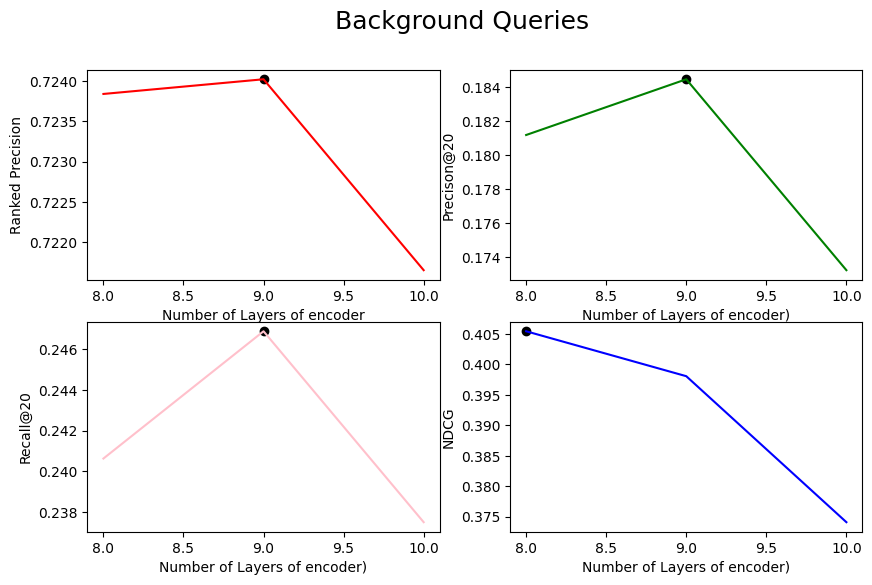

<Figure size 640x480 with 0 Axes>

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
fig.suptitle(' Background Queries ', fontsize=18)
xpoints = np.array(n_layers)
ypoints = np.array(ndcg_background)
max_y = max(ypoints)
i = 0
for ndcg in ndcg_background:
  if ndcg == max_y:
    break
  i += 1
plt.xlabel("Number of Layers of encoder)")
plt.ylabel("NDCG")
plt.subplot(2,2,1)
plt.plot(xpoints[i], max_y, 'ro', color = 'black')
plt.plot(xpoints, ypoints, color = 'red')

ypoints = np.array(r_precision_background)
max_y = max(ypoints)
i = 0
for ndcg in r_precision_background:
  if ndcg == max_y:
    break
  i += 1
plt.xlabel("Number of Layers of encoder")
plt.ylabel("Ranked Precision")
plt.subplot(2,2,2)
plt.plot(xpoints[i], max_y, 'ro', color = 'black')
plt.plot(xpoints, ypoints, color = 'green')


ypoints = np.array(precision_background)
max_y = max(ypoints)
i = 0
for ndcg in precision_background:
  if ndcg == max_y:
    break
  i += 1
plt.xlabel("Number of Layers of encoder)")
plt.ylabel("Precison@20")
plt.subplot(2,2,3)
plt.plot(xpoints[i], max_y, 'ro', color = 'black')
plt.plot(xpoints, ypoints, color = 'pink')

ypoints = np.array(recall_background)
max_y = max(ypoints)
i = 0
for ndcg in recall_background:
  if ndcg == max_y:
    break
  i += 1
plt.xlabel("Number of Layers of encoder)")
plt.ylabel("Recall@20")
plt.subplot(2,2,4)
plt.plot(xpoints[i], max_y, 'ro', color = 'black')
plt.plot(xpoints, ypoints, color = 'blue')

plt.show()
plt.savefig('/content/drive/MyDrive/data/plot/bg.png')

<ipython-input-49-7bca3b6b4a9d>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xpoints[i], max_y, 'ro', color = 'black')
<ipython-input-49-7bca3b6b4a9d>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xpoints[i], max_y, 'ro', color = 'black')
<ipython-input-49-7bca3b6b4a9d>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xpoints[i], max_y, 'ro', color = 'black')
<ipython-input-49-7bca3b6b4a9d>:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xpoints[i], max_y, 'ro', color = 'black')


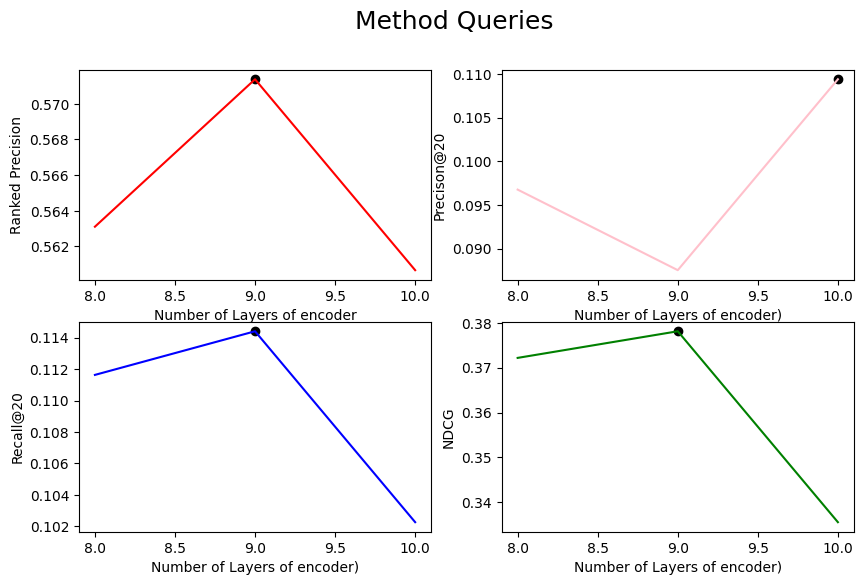

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
fig.suptitle(' Method Queries ', fontsize=18)
xpoints = np.array(n_layers)
ypoints = np.array(ndcg_method)
max_y = max(ypoints)
i = 0
for ndcg in ndcg_method:
  if ndcg == max_y:
    break
  i += 1
plt.xlabel("Number of Layers of encoder)")
plt.ylabel("NDCG")
plt.subplot(2,2,1)
plt.plot(xpoints[i], max_y, 'ro', color = 'black')
plt.plot(xpoints, ypoints, color = 'red')

ypoints = np.array(r_precision_method)
max_y = max(ypoints)
i = 0
for ndcg in r_precision_method:
  if ndcg == max_y:
    break
  i += 1
plt.xlabel("Number of Layers of encoder")
plt.ylabel("Ranked Precision")
plt.subplot(2,2,2)
plt.plot(xpoints[i], max_y, 'ro', color = 'black')
plt.plot(xpoints, ypoints, color = 'pink')


ypoints = np.array(precision_method)
max_y = max(ypoints)
i = 0
for ndcg in precision_method:
  if ndcg == max_y:
    break
  i += 1
plt.xlabel("Number of Layers of encoder)")
plt.ylabel("Precison@20")
plt.subplot(2,2,3)
plt.plot(xpoints[i], max_y, 'ro', color = 'black')
plt.plot(xpoints, ypoints, color = 'blue')

ypoints = np.array(recall_method)
max_y = max(ypoints)
i = 0
for ndcg in recall_method:
  if ndcg == max_y:
    break
  i += 1
plt.xlabel("Number of Layers of encoder)")
plt.ylabel("Recall@20")
plt.subplot(2,2,4)
plt.plot(xpoints[i], max_y, 'ro', color = 'black')
plt.plot(xpoints, ypoints, color = 'green')

plt.savefig('/content/drive/MyDrive/data/plot/me.png')
plt.show()

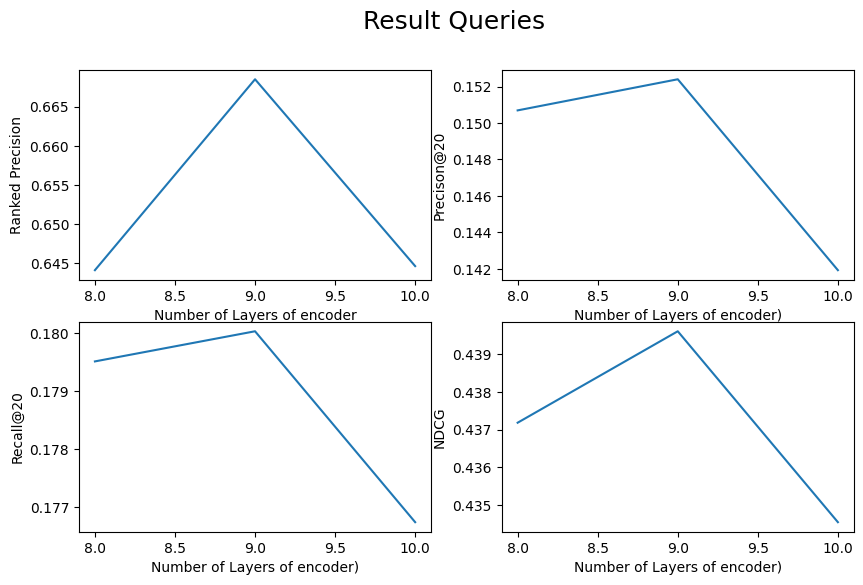

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
fig.suptitle(' Result Queries ', fontsize=18)
xpoints = np.array(n_layers)
ypoints = np.array(ndcg_result)

plt.xlabel("Number of Layers of encoder)")
plt.ylabel("NDCG")
plt.subplot(2,2,1)
plt.plot(xpoints, ypoints)

ypoints = np.array(r_precision_result)
plt.xlabel("Number of Layers of encoder")
plt.ylabel("Ranked Precision")
plt.subplot(2,2,2)
plt.plot(xpoints, ypoints)


ypoints = np.array(precision_result)
plt.xlabel("Number of Layers of encoder)")
plt.ylabel("Precison@20")
plt.subplot(2,2,3)
plt.plot(xpoints, ypoints)

ypoints = np.array(recall_result)
plt.xlabel("Number of Layers of encoder)")
plt.ylabel("Recall@20")
plt.subplot(2,2,4)
plt.plot(xpoints, ypoints)

plt.show()

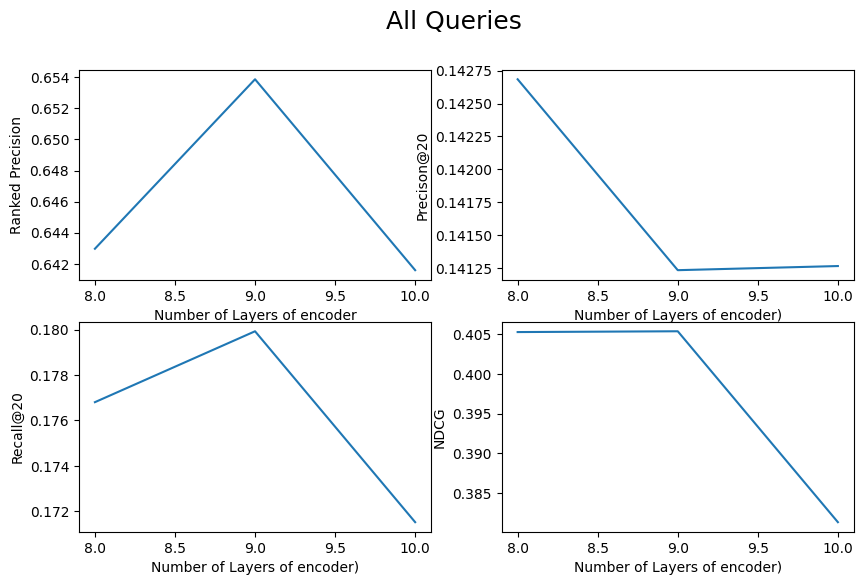

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
fig.suptitle(' All Queries ', fontsize=18)
xpoints = np.array(n_layers)
ypoints = np.array(ndcg_all)

plt.xlabel("Number of Layers of encoder)")
plt.ylabel("NDCG")
plt.subplot(2,2,1)
plt.plot(xpoints, ypoints)

ypoints = np.array(r_precision_all)
plt.xlabel("Number of Layers of encoder")
plt.ylabel("Ranked Precision")
plt.subplot(2,2,2)
plt.plot(xpoints, ypoints)


ypoints = np.array(precision_all)
plt.xlabel("Number of Layers of encoder)")
plt.ylabel("Precison@20")
plt.subplot(2,2,3)
plt.plot(xpoints, ypoints)

ypoints = np.array(recall_all)
plt.xlabel("Number of Layers of encoder)")
plt.ylabel("Recall@20")
plt.subplot(2,2,4)
plt.plot(xpoints, ypoints)

plt.show()